# Moon Viewing Calendar 
## Moon & Sun Heights in the Sky
### Charted new moon to new moon

In [5]:
import warnings
warnings.filterwarnings('ignore')

import ephem
from astropy.time import Time
from astropy.coordinates import get_moon, get_sun, AltAz, EarthLocation
import astropy.units as u
from datetime import timedelta
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Calculating Sun and Moon positions for 13 lunar cycles...


Calculating cycle 1/13: 0it [00:05, ?it/s]
Calculating cycle 2/13: 0it [00:05, ?it/s]
Calculating cycle 3/13: 0it [00:05, ?it/s]
Calculating cycle 4/13: 0it [00:05, ?it/s]
Calculating cycle 5/13: 0it [00:05, ?it/s]
Calculating cycle 6/13: 0it [00:05, ?it/s]
Calculating cycle 7/13: 0it [00:05, ?it/s]
Calculating cycle 8/13: 0it [00:05, ?it/s]
Calculating cycle 9/13: 0it [00:05, ?it/s]
Calculating cycle 10/13: 0it [00:05, ?it/s]
Calculating cycle 11/13: 0it [00:05, ?it/s]
Calculating cycle 12/13: 0it [00:05, ?it/s]
Calculating cycle 13/13: 0it [00:05, ?it/s]


Generating plots...


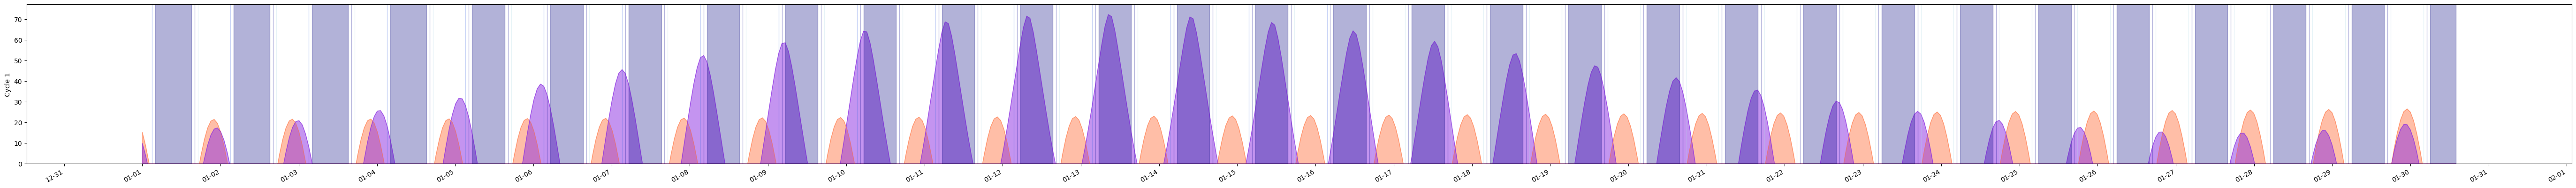

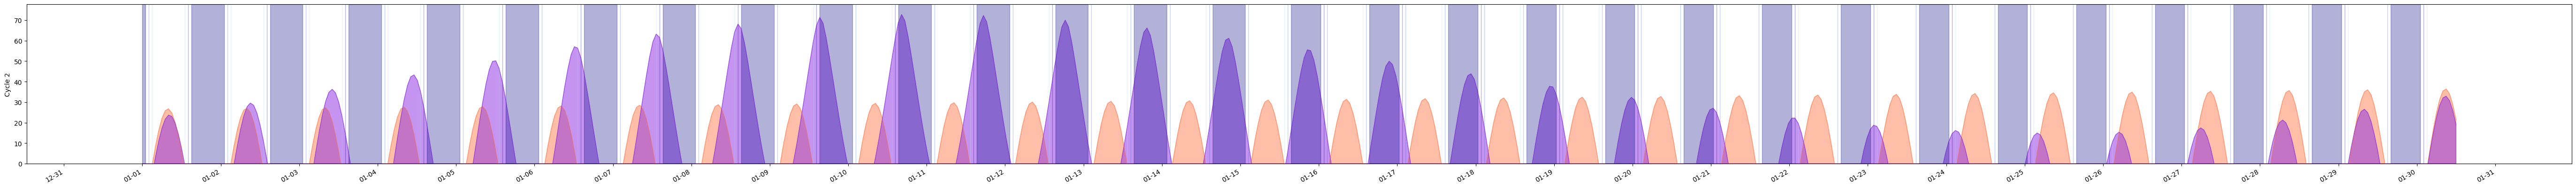

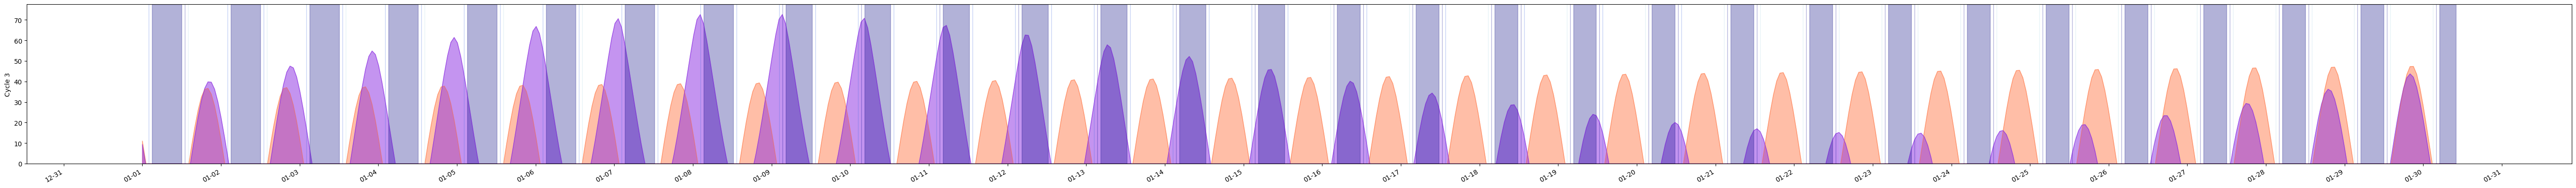

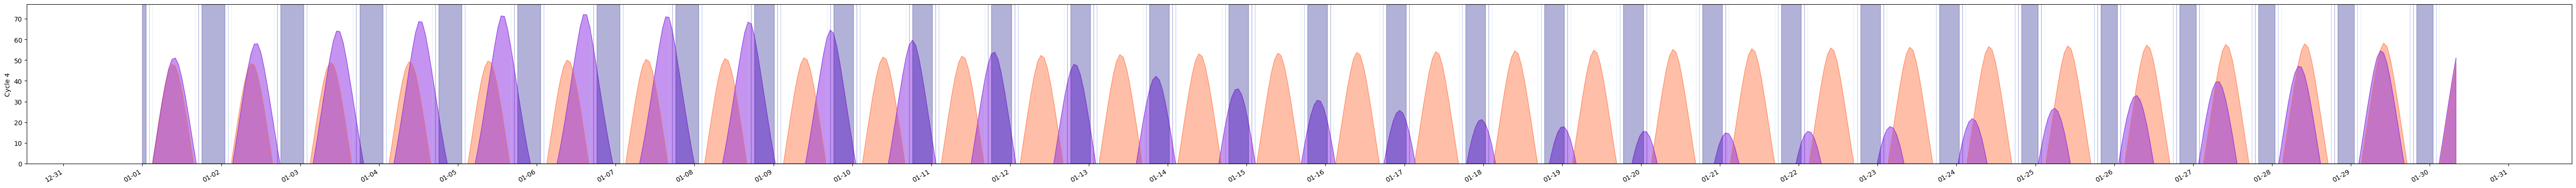

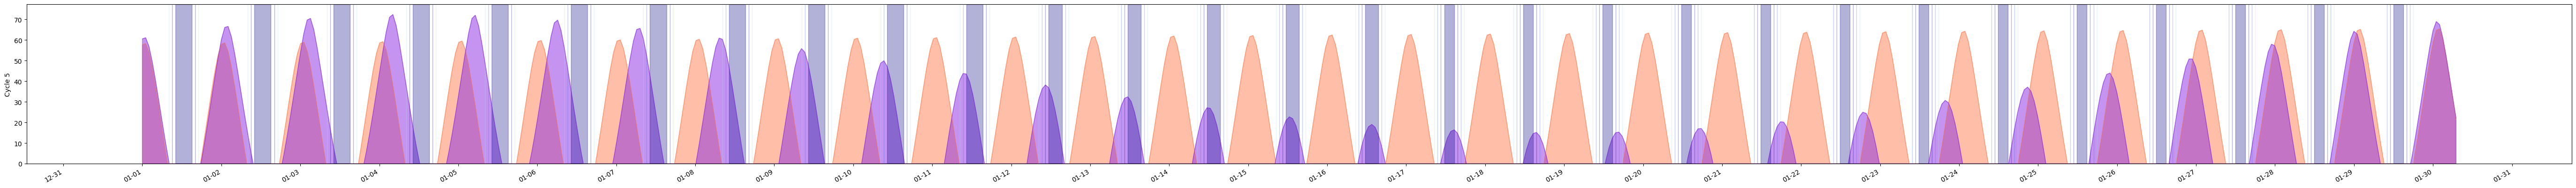

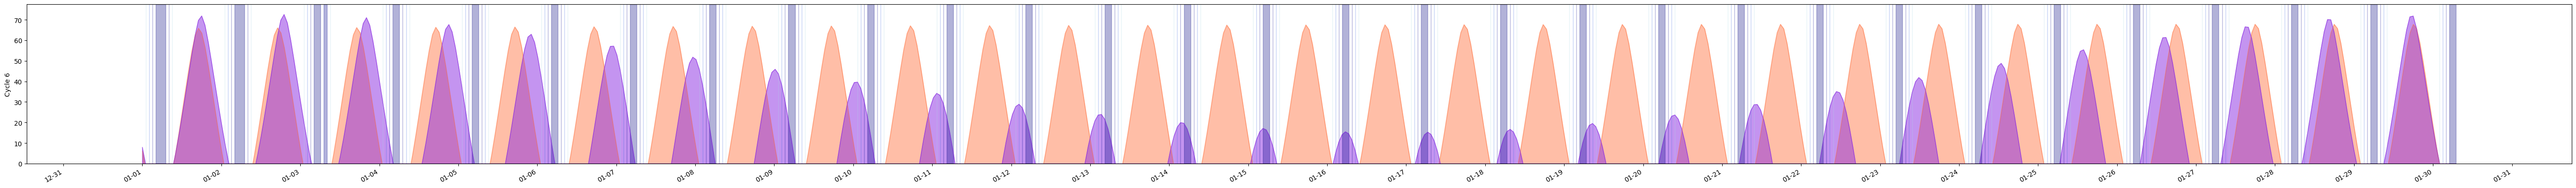

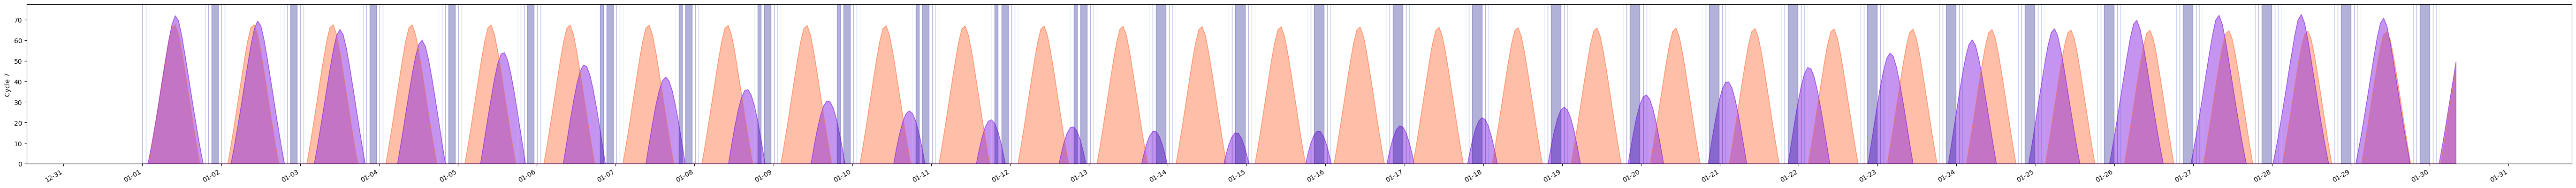

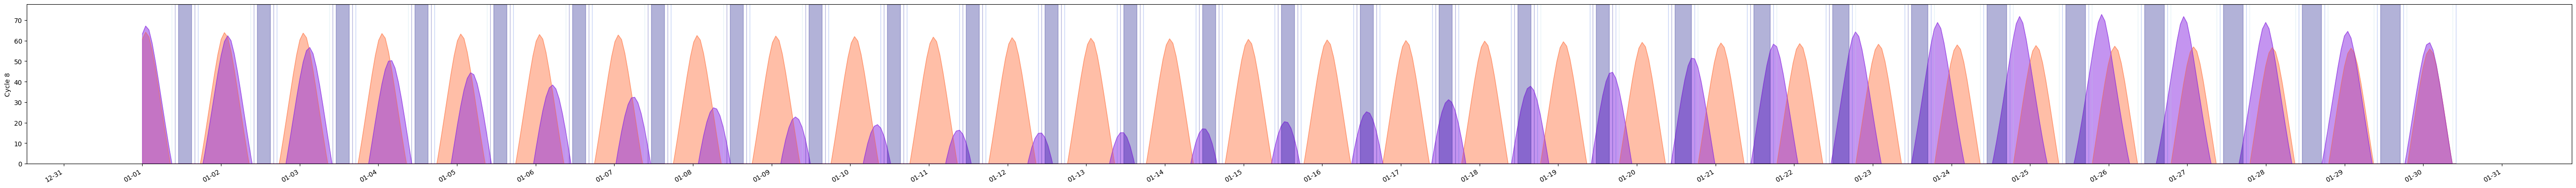

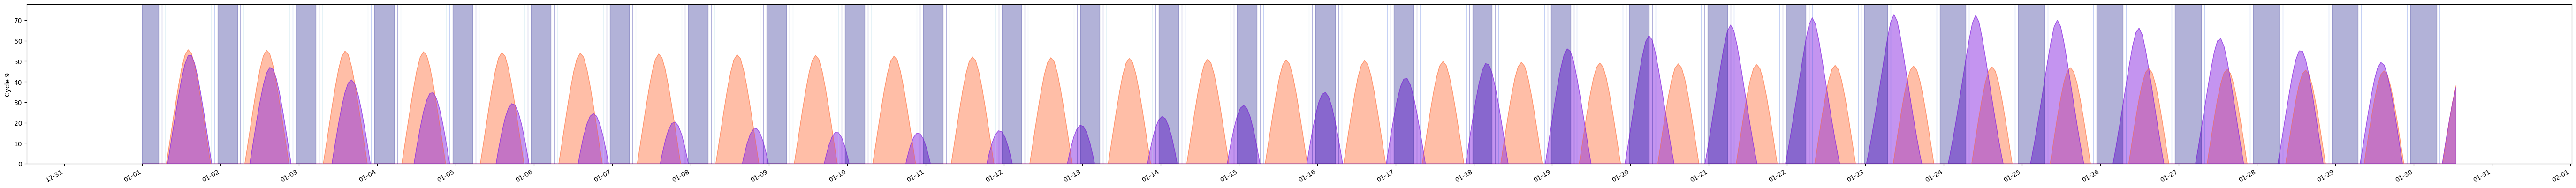

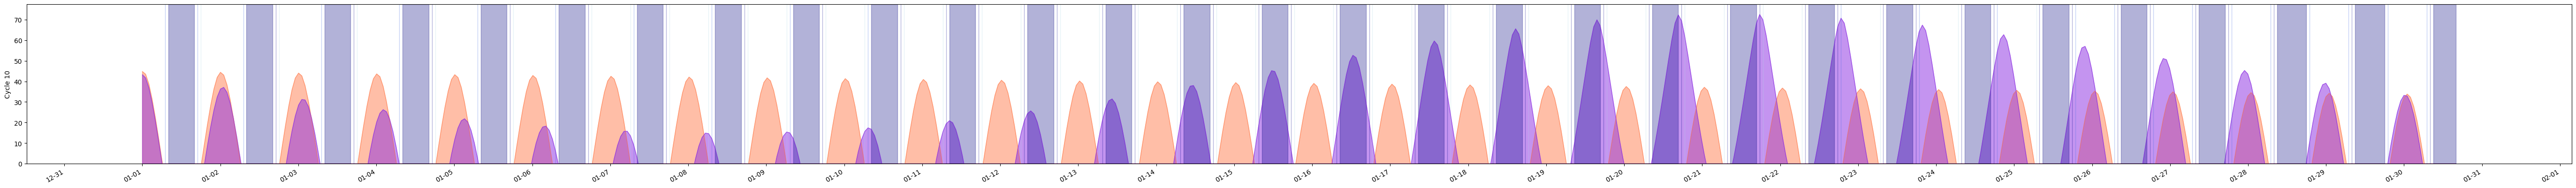

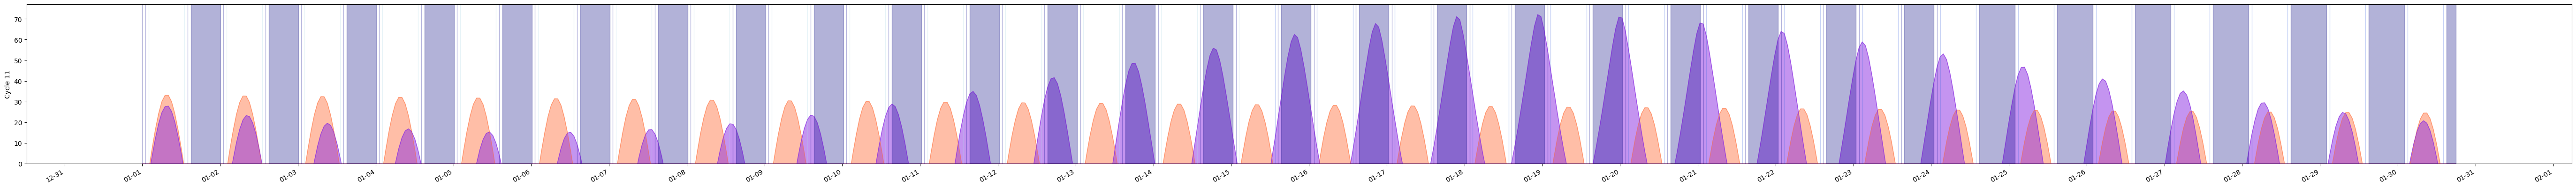

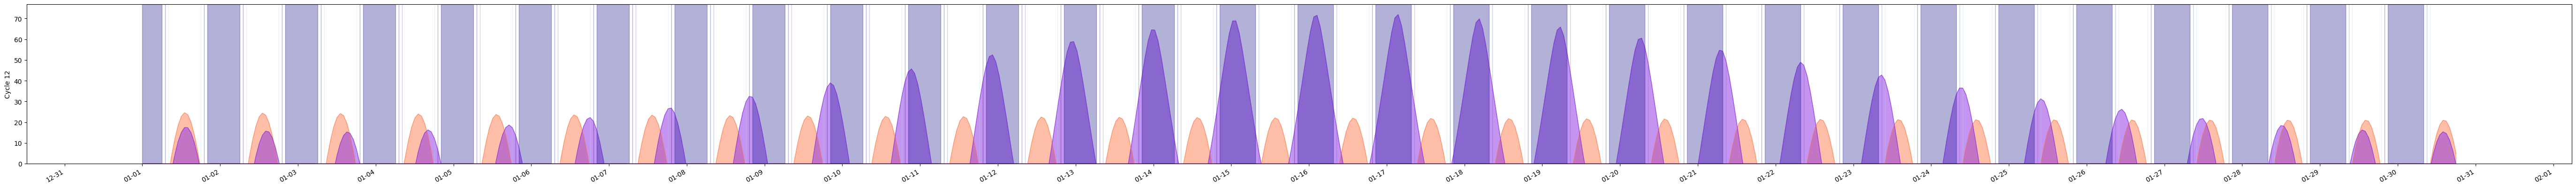

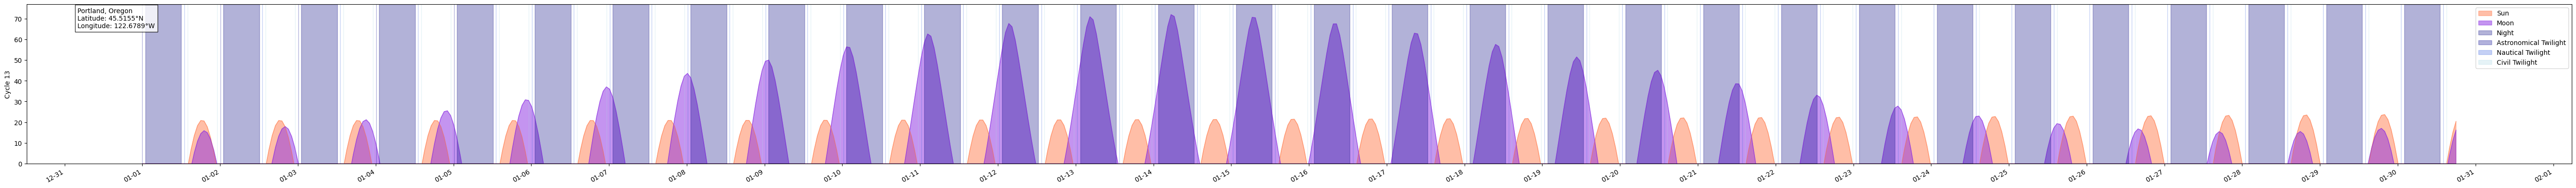

In [6]:
def calculate_moon_phase(date):
    moon = ephem.Moon()
    moon.compute(date)
    return moon.phase / 100.0

def find_new_moons(start_date, end_date):
    new_moons = []
    current = ephem.Date(start_date.datetime)
    end = ephem.Date(end_date.datetime)
    
    while current < end:
        next_new = ephem.next_new_moon(current)
        if next_new > end:
            break
        new_moons.append(Time(ephem.Date(next_new).datetime()))
        current = ephem.Date(next_new + 1)
    return new_moons

def calculate_cycle_data(cycle_start, cycle_end, location):
    hours_total = int((cycle_end - cycle_start).jd * 24)
    times = [cycle_start + timedelta(hours=h) for h in range(hours_total)]
    times = Time(times)
    
    moon_altitudes = []
    sun_altitudes = []
    moon_phases = []
    
    for t in times:
        moon = get_moon(t)
        moon_altaz = moon.transform_to(AltAz(obstime=t, location=location))
        moon_altitudes.append(moon_altaz.alt.degree)
        
        sun = get_sun(t)
        sun_altaz = sun.transform_to(AltAz(obstime=t, location=location))
        sun_altitudes.append(sun_altaz.alt.degree)
        
        moon_phases.append(calculate_moon_phase(t.datetime))
    
    days = np.linspace(0, len(times)/24, len(times))
    return days, sun_altitudes, moon_altitudes, moon_phases

def plot_cycle(days, sun_altitudes, moon_altitudes, cycle_num, latitude, longitude):
    plt.figure(figsize=(70, 5))
    
    plt.fill_between(days, 0, sun_altitudes, color='coral', alpha=0.5, label='Sun')
    plt.fill_between(days, 0, moon_altitudes, color='blueviolet', alpha=0.5, label='Moon')
    
    plt.plot(days, sun_altitudes, 'coral', linewidth=1, alpha=0.5)
    plt.plot(days, moon_altitudes, 'blueviolet', linewidth=1, alpha=0.5)
    
    y_max = max(max([max(0, alt) for alt in sun_altitudes]), 
               max([max(0, alt) for alt in moon_altitudes])) + 5
    
    # Add twilight bands
    plt.fill_between(days, 0, y_max, 
                    where=[alt <= -18 for alt in sun_altitudes],
                    color='navy', alpha=0.3, label='Night')
    
    plt.fill_between(days, 0, y_max,
                    where=[(-18 <= alt <= -12) for alt in sun_altitudes],
                    color='darkblue', alpha=0.3, label='Astronomical Twilight')
    
    plt.fill_between(days, 0, y_max,
                    where=[(-12 <= alt <= -6) for alt in sun_altitudes],
                    color='royalblue', alpha=0.3, label='Nautical Twilight')
    
    plt.fill_between(days, 0, y_max,
                    where=[(-6 <= alt <= 0) for alt in sun_altitudes],
                    color='lightblue', alpha=0.3, label='Civil Twilight')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())

    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=120))
    plt.gcf().autofmt_xdate()
    plt.ylabel(f'Cycle {cycle_num + 1}')
    plt.ylim(0, y_max)
    
def plot_sun_moon(latitude, longitude):
    location = EarthLocation(lat=latitude * u.deg, lon=longitude * u.deg)
    
    start_date = Time('2024-12-29 00:00:00')
    end_date = Time('2026-01-29 00:00:00')
    new_moons = find_new_moons(start_date, end_date)
    
    n_cycles = len(new_moons) - 1
    print(f"Calculating Sun and Moon positions for {n_cycles} lunar cycles...")
    
    # Calculate all cycle data first
    cycle_data = []
    for cycle in range(n_cycles):
        cycle_start = new_moons[cycle]
        cycle_end = new_moons[cycle + 1]
        with tqdm(desc=f"Calculating cycle {cycle + 1}/{n_cycles}"):
            data = calculate_cycle_data(cycle_start, cycle_end, location)
            cycle_data.append(data)
    
    # Plot all cycles
    print("Generating plots...")
    for cycle, (days, sun_altitudes, moon_altitudes, moon_phases) in enumerate(cycle_data):
        plot_cycle(days, sun_altitudes, moon_altitudes, cycle, latitude, longitude)
    info_text = f"Portland, Oregon \nLatitude: {latitude}°N\nLongitude: {abs(longitude)}°W"
    plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    plt.legend()
    plt.show()

# Portland, Oregon
latitude = 45.5155
longitude = -122.6789

# Spokane, Washington
#latitude = 47.658779
#longitude = -117.426048

plot_sun_moon(latitude, longitude)